## Carga de datos

In [134]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D,Dropout,Conv2DTranspose, UpSampling2D, concatenate
from tensorflow.keras.models import load_model

# Paso 1: Cargar los datos
data_folder = "./Dataset"
image_folder = os.path.join(data_folder, "train_images_256")
mask_folder = os.path.join(data_folder, "train_masks_256")

# Obtener lista de nombres de archivo para las imágenes
image_files = os.listdir(image_folder)

2023-07-25 17:26:07.410963: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-25 17:26:07.544141: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-07-25 17:26:08.120722: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/name/miniconda3/envs/tf/lib/python3.9/site-packages/cv2/../../lib64:/home/name/miniconda3/envs/tf/lib/:/home/name/miniconda3/envs/tf/lib/python3.9/site-packages/nvidia/cudnn/lib:/home/name/miniconda3/envs/t

In [135]:
print("TensorFlow version:", tf.__version__)

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

TensorFlow version: 2.13.0


## Preprocesamiento de Datos

In [136]:

# Paso 2: Preparar los datos
# Redimensionar todas las imágenes a un tamaño específico
image_size = (256, 256)

# Crear listas para almacenar las imágenes y sus máscaras
images = []
masks = []

# cargar imagenes y mascaras
for filename in image_files:
    image_path = os.path.join(image_folder, filename)
    mask_path = os.path.join(mask_folder, filename)

    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # image = cv2.resize(image, image_size)
    # mask = cv2.resize(mask, image_size)

    # Normalizar las imágenes y máscaras para que los valores estén entre 0 y 1
    image = image / 255.0
    mask = mask / 255.0

    # Cambiar los píxeles en la máscara mayores que 0 a 255
    # mask[mask > 0] = 255

    images.append(image)
    masks.append(mask)


# Convertir las listas de imágenes y máscaras a arreglos numpy
images = np.array(images)
masks = np.array(masks)

# Agregar una dimensión adicional para el canal (ya que las imágenes están en escala de grises)
images = np.expand_dims(images, axis=-1)
masks = np.expand_dims(masks, axis=-1)




In [13]:
# image_files = os.listdir(image_folder)
# half_length = len(image_files) // 4
# image_files = image_files[:half_length]

# print(len(image_files))

## Modelo U-net

In [137]:


def unet(input_layer=(256, 256, 1), start_neurons=16):
    inputs = Input(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(inputs)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)
    
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)

    model = Model(inputs=inputs, outputs=output_layer)
    
    return model



## Carga y Entrenamiento del modelo
#### - save: para entrenar por primera vez
#### -  load: para cargar un modelo pre-entrenado

In [138]:


save_load = "load"

#nombre del modelo pre-entrenado
model_name = "model_30_epocas.h5"

model  = None

if save_load == "save":
    model = unet(input_layer=(256,256,1), start_neurons=32)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(images, masks, batch_size=8, epochs=10, validation_split=0.2)
    model.save("./DataSave/" + model_name)
else:
    model = tf.keras.models.load_model("./DataSave/" + model_name)

## Test de Mascara 

1/1 [==============================] - 0s 81ms/step


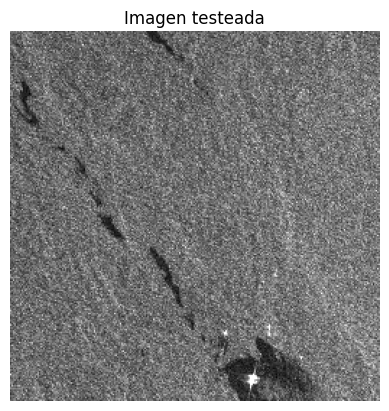

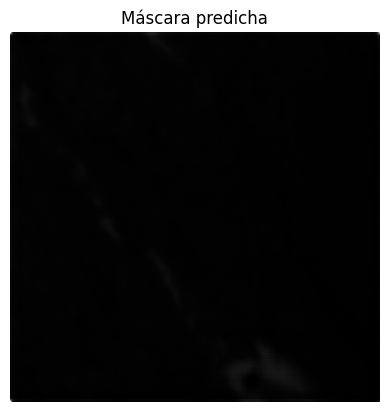

In [140]:

# ejemplo de predicción
image_path = "./Dataset/train_images_256/041871.000163.tif"
# image_path = "./image_input_partition/L15-0585E-0954Ngray_part134.tif"

test_image = cv2.imread( image_path, cv2.IMREAD_GRAYSCALE)
test_image = cv2.resize(test_image, image_size)
test_image = test_image.astype('float32') / 255.0
test_image = np.expand_dims(test_image, axis=0)
test_image = np.expand_dims(test_image, axis=-1)

predicted_mask = model.predict(test_image)


# Mostrar la imagen testeada
plt.imshow(test_image[0, :, :, 0], cmap='gray')
plt.title('Imagen testeada')
plt.axis('off')
plt.show()


#Mostrar la máscara predicha
predicted_mask = predicted_mask.squeeze()
plt.imshow(predicted_mask, cmap='gray')
plt.title('Máscara predicha')
plt.axis('off')
plt.show()


